# UNReLo Weather-Forecasting Model
This is a custom model created to forecast weather elements i.e humidity and temperature using weather data collected for over 5 years

Import packages

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
import joblib
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

Load data from the CSV file

In [289]:
raw_weather = pd.read_csv("data/TA00026.csv", index_col='timestamp (UTC)')

# Exploratory Data Analysis

In [290]:
print(raw_weather.shape)
raw_weather.describe()

(43824, 7)


,precipitation (mm),relativehumidity AVG (-),soilmoisture S001263 AVG (m3/m3),soilmoisture S001391 AVG (m3/m3),temperature AVG (degrees Celsius),temperature MAX (degrees Celsius),temperature MIN (degrees Celsius)
count,43802.000000,43741.000000,5007.000000,22481.000000,43773.000000,43773.000000,43773.000000
mean,0.117269,0.715176,0.195224,0.187951,17.752863,18.421413,17.104834
std,1.266188,0.200471,0.062109,0.048850,4.503781,4.615403,4.427316
min,0.000000,0.081417,0.115000,0.113250,6.575000,7.000000,6.000000
25%,0.000000,0.580833,0.133458,0.145000,14.366667,14.800000,13.900000
50%,0.000000,0.742167,0.182364,0.189000,17.100000,17.800000,16.400000
75%,0.000000,0.883500,0.258000,0.231917,21.166667,22.000000,20.400000
max,112.300000,1.000000,0.334500,0.340000,31.008333,32.000000,30.500000


In [291]:
raw_weather.head()

,precipitation (mm),relativehumidity AVG (-),soilmoisture S001263 AVG (m3/m3),soilmoisture S001391 AVG (m3/m3),temperature AVG (degrees Celsius),temperature MAX (degrees Celsius),temperature MIN (degrees Celsius)
timestamp (UTC),,,,,,,
2018-01-01 00:00,0.0,0.728333,NaN,NaN,13.166667,14.3,12.2
2018-01-01 01:00,0.0,0.785000,NaN,NaN,11.925000,12.2,11.6
2018-01-01 02:00,0.0,0.819167,NaN,NaN,11.041667,11.5,10.5
2018-01-01 03:00,0.0,0.853333,NaN,NaN,10.333333,10.5,10.2
2018-01-01 04:00,0.4,0.805833,NaN,NaN,12.633333,15.8,10.3


In [292]:
weather=raw_weather[['temperature AVG (degrees Celsius)','relativehumidity AVG (-)']]
weather.columns=['avg_temp','avg_humidity']
weather.head()

,avg_temp,avg_humidity
timestamp (UTC),,
2018-01-01 00:00,13.166667,0.728333
2018-01-01 01:00,11.925000,0.785000
2018-01-01 02:00,11.041667,0.819167
2018-01-01 03:00,10.333333,0.853333
2018-01-01 04:00,12.633333,0.805833


Check for null/missing values

In [293]:
weather.apply(pd.isnull).sum()/weather.shape[0]

avg_temp        0.001164
avg_humidity    0.001894
dtype: float64

Deal with missing values

In [294]:
#fill with previous value
weather=weather.fillna(method='ffill')
weather.apply(pd.isnull).sum()/weather.shape[0]

avg_temp        0.0
avg_humidity    0.0
dtype: float64

Checking for outliers

In [295]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

check_outlier(weather,['avg_temp','avg_humidity'])

False

Make sure we have correct data types

In [296]:
#convert index type to datetime
weather.index=pd.to_datetime(weather.index)
weather.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp (UTC)', length=43824, freq=None)

Visualize the data 

<Axes: xlabel='timestamp (UTC)'>

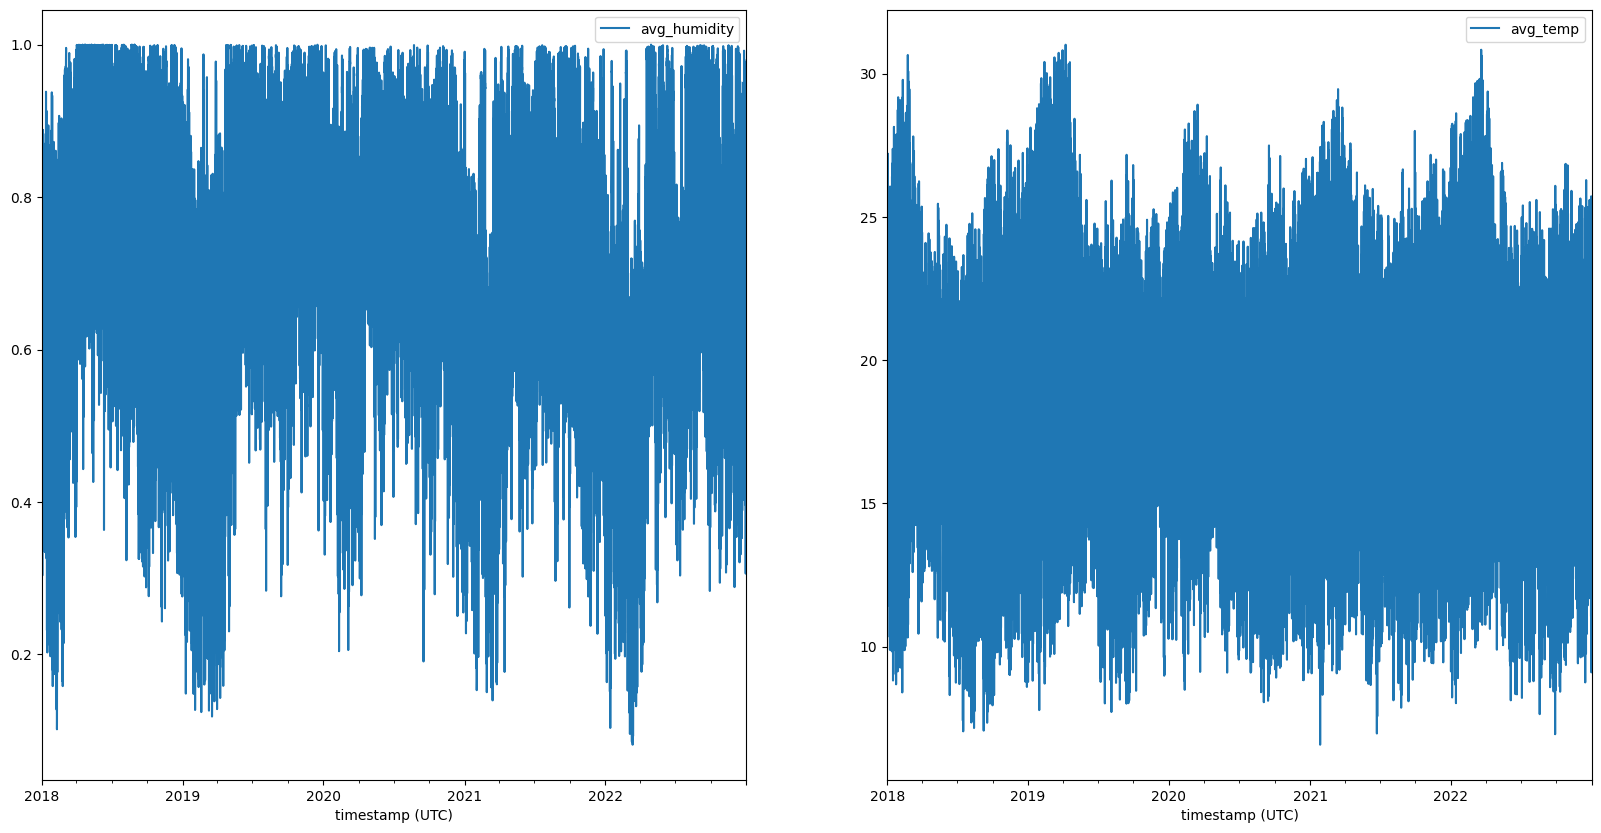

In [297]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
weather[['avg_humidity']].plot(ax=ax[0])
weather[['avg_temp']].plot(ax=ax[1])

See the trend and nature of data

<Axes: xlabel='timestamp (UTC)'>

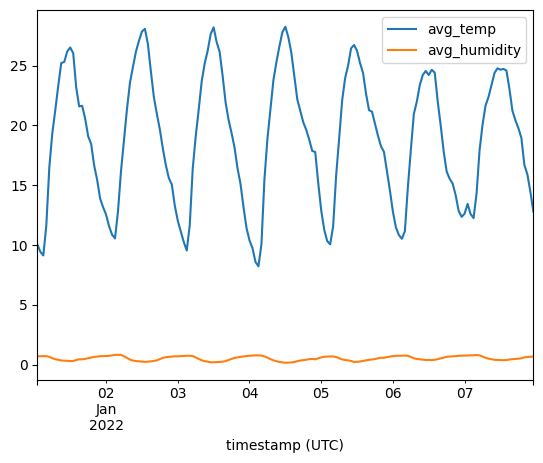

In [298]:
weather.loc[(weather.index>'2022-01-01')&(weather.index<'2022-01-08')].plot()

Feature engineering

In [299]:
def create_features(weather):
    weather=weather.copy()
    weather['hour']=weather.index.hour
    weather['dayofweek']=weather.index.dayofweek
    weather['quarter']=weather.index.quarter
    weather['month']=weather.index.month
    weather['year']=weather.index.year
    weather['dayofyear']=weather.index.dayofyear
    return weather

weather=create_features(weather)
weather

,avg_temp,avg_humidity,hour,dayofweek,quarter,month,year,dayofyear
timestamp (UTC),,,,,,,,
2018-01-01 00:00:00,13.166667,0.728333,0,0,1,1,2018,1
2018-01-01 01:00:00,11.925000,0.785000,1,0,1,1,2018,1
2018-01-01 02:00:00,11.041667,0.819167,2,0,1,1,2018,1
2018-01-01 03:00:00,10.333333,0.853333,3,0,1,1,2018,1
2018-01-01 04:00:00,12.633333,0.805833,4,0,1,1,2018,1
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,17.983333,0.537333,19,5,4,12,2022,365
2022-12-31 20:00:00,18.133333,0.477000,20,5,4,12,2022,365
2022-12-31 21:00:00,17.575000,0.494167,21,5,4,12,2022,365


# Train-Validation Split

In [300]:
train=weather.loc[weather.index<'2022-01-01']
test=weather.loc[weather.index>='2022-01-01']
train.shape,test.shape

((35064, 8), (8760, 8))

<Axes: xlabel='timestamp (UTC)'>

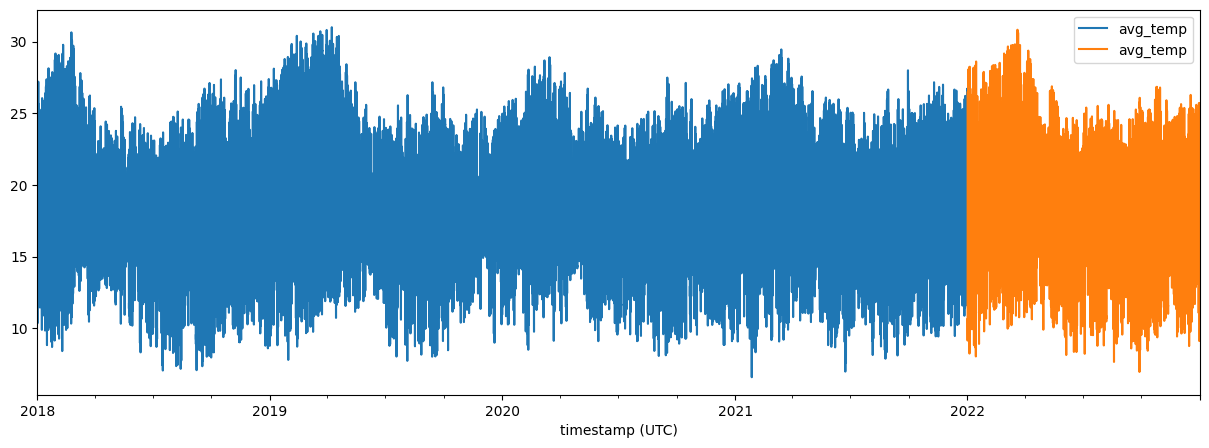

In [301]:
#drop last row since it has no target
fig, ax=plt.subplots(figsize=(15,5))
train[['avg_temp']].plot(ax=ax)
test[['avg_temp']].plot(ax=ax)

<Axes: xlabel='timestamp (UTC)'>

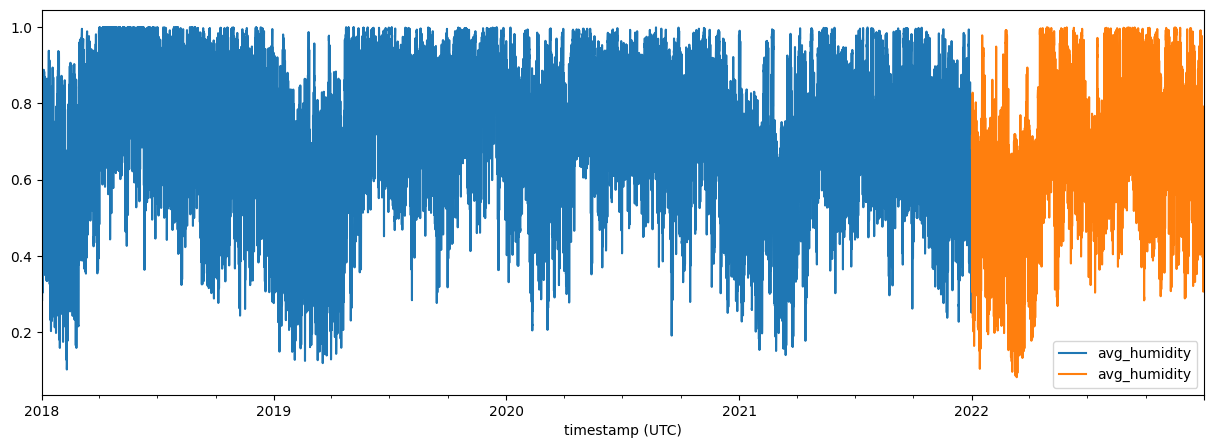

In [302]:
fig, ax=plt.subplots(figsize=(15,5))
train[['avg_humidity']].plot(ax=ax)
test[['avg_humidity']].plot(ax=ax)

In [303]:
train=create_features(train)
test=create_features(test)
features=['dayofweek','quarter','month','year','dayofyear','hour']
target=['avg_temp','avg_humidity']

In [304]:
X_train=train[features]
y_train=train[target]

X_test=test[features]
y_test=test[target]

# Create the model

Using CatBoost Regressor

In [305]:
cat_model = CatBoostRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01,loss_function='MultiRMSE')
cat_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

cat_pred = cat_model.predict(X_test)

print("Mean squared error on testing data: {:.4f}".format(mean_squared_error(y_test,cat_pred)))
print("Mean absolute error on testing data: {:.4f}".format(mean_absolute_error(y_test,cat_pred)))
print("Mean absolute percentage error on testing data: {:.4f}".format(np.mean(np.abs((y_test - cat_pred) / y_test)) * 100))

0:	learn: 4.4364025	test: 4.4364025	test1: 4.6253107	best: 4.6253107 (0)	total: 12.4ms	remaining: 12.4s
100:	learn: 2.5771653	test: 2.5771653	test1: 2.7152779	best: 2.7152779 (100)	total: 888ms	remaining: 7.9s
200:	learn: 2.0985665	test: 2.0985665	test1: 2.2202039	best: 2.2202039 (200)	total: 1.6s	remaining: 6.36s
300:	learn: 1.9529431	test: 1.9529431	test1: 2.0982569	best: 2.0982569 (300)	total: 2.3s	remaining: 5.33s
400:	learn: 1.8921677	test: 1.8921677	test1: 2.0554908	best: 2.0554908 (400)	total: 3.36s	remaining: 5.02s
500:	learn: 1.8568689	test: 1.8568689	test1: 2.0366127	best: 2.0366127 (500)	total: 4.95s	remaining: 4.93s
600:	learn: 1.8344043	test: 1.8344043	test1: 2.0243822	best: 2.0241829 (599)	total: 6.13s	remaining: 4.07s
700:	learn: 1.8155289	test: 1.8155289	test1: 2.0184543	best: 2.0184543 (700)	total: 7.26s	remaining: 3.1s
800:	learn: 1.7989251	test: 1.7989251	test1: 2.0160527	best: 2.0158200 (799)	total: 8.52s	remaining: 2.12s
Stopped by overfitting detector  (50 iterati

Using Random Forest Regressor

In [306]:
rf_model = RandomForestRegressor(n_estimators=1000,random_state=42)
rf_model.fit(X_train,y_train)

rf_pred = rf_model.predict(X_test)


print("Mean squared error on testing data: {:.4f}".format(mean_squared_error(y_test,rf_pred)))
print("Mean absolute error on testing data: {:.4f}".format(mean_absolute_error(y_test,rf_pred)))
print("Mean absolute percentage error on testing data: {:.4f}".format(np.mean(np.abs((y_test - rf_pred) / y_test)) * 100))


Mean squared error on testing data: 2.8233
Mean absolute error on testing data: 0.9531
Mean absolute percentage error on testing data: 16.6461


Using XGBOOST Regressor

In [307]:
reg= xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

predictions=reg.predict(X_test)

print("Mean squared error on testing data: {:.4f}".format(mean_squared_error(y_test,predictions)))
print("Mean absolute error on testing data: {:.4f}".format(mean_absolute_error(y_test,predictions)))
print("Mean absolute percentage error on testing data: {:.4f}".format(np.mean(np.abs((y_test - predictions) / y_test)) * 100))



[0]	validation_0-rmse:12.47046	validation_1-rmse:12.55717
[100]	validation_0-rmse:4.74704	validation_1-rmse:4.88237
[200]	validation_0-rmse:2.12008	validation_1-rmse:2.30632
[300]	validation_0-rmse:1.40532	validation_1-rmse:1.59562
[400]	validation_0-rmse:1.25202	validation_1-rmse:1.44495
[500]	validation_0-rmse:1.20244	validation_1-rmse:1.42222
[586]	validation_0-rmse:1.17871	validation_1-rmse:1.42241
Mean squared error on testing data: 2.0192
Mean absolute error on testing data: 0.8304
Mean absolute percentage error on testing data: 14.8109


Combine the data with prediction

In [308]:
combined=pd.concat([y_test,pd.DataFrame(data=predictions,index=y_test.index,columns=['predicted_temp','predicted_humidity'],)],axis=1)
combined.sort_index(inplace=True)
combined

,avg_temp,avg_humidity,predicted_temp,predicted_humidity
timestamp (UTC),,,,
2022-01-01 00:00:00,10.625000,0.682417,14.329355,0.853423
2022-01-01 01:00:00,10.058333,0.695167,13.269287,0.881681
2022-01-01 02:00:00,9.441667,0.708000,12.580580,0.903807
2022-01-01 03:00:00,9.133333,0.716750,12.263237,0.921955
2022-01-01 04:00:00,11.633333,0.714167,13.160879,0.926575
...,...,...,...,...
2022-12-31 19:00:00,17.983333,0.537333,17.600962,0.591197
2022-12-31 20:00:00,18.133333,0.477000,16.898304,0.594414
2022-12-31 21:00:00,17.575000,0.494167,15.996138,0.631583


Feature importance

<Axes: >

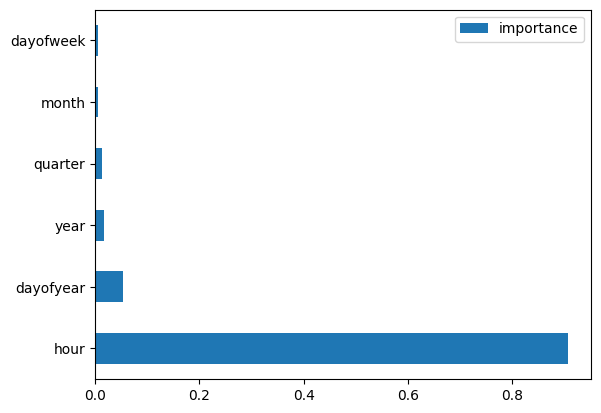

In [309]:
fi=pd.DataFrame(data=reg.feature_importances_,index= reg.feature_names_in_,columns=['importance']).sort_values(by='importance',ascending=False)
fi.plot(kind='barh')

Plot the prediction

<Axes: xlabel='timestamp (UTC)'>

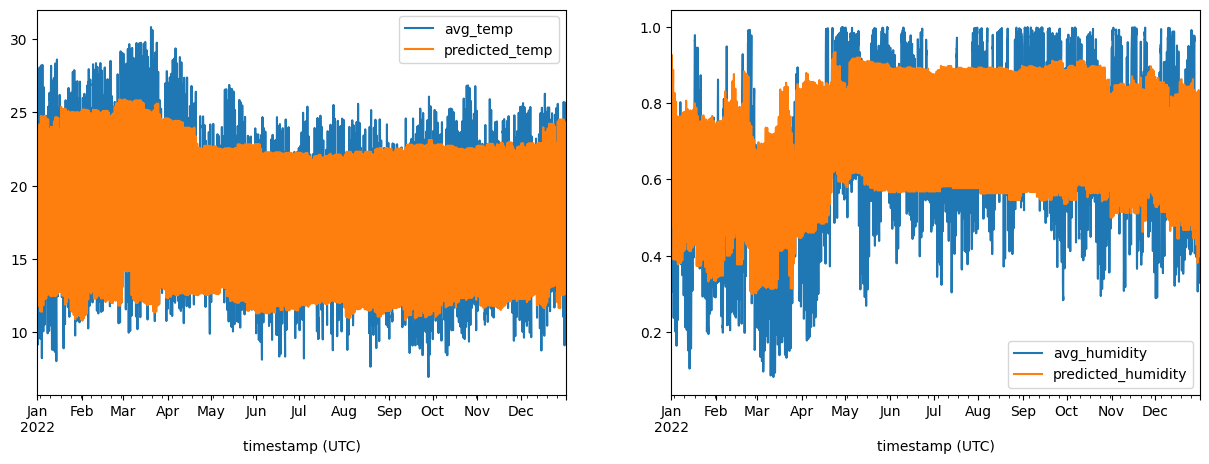

In [310]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
combined[['avg_temp','predicted_temp']].plot(ax=ax[0])
combined[['avg_humidity','predicted_humidity']].plot(ax=ax[1])


<Axes: xlabel='timestamp (UTC)'>

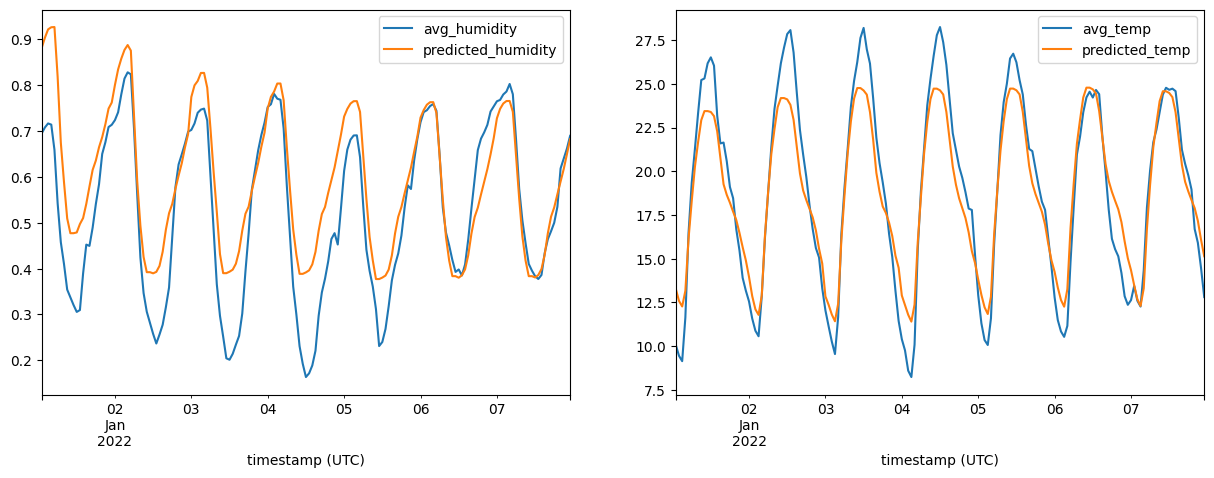

In [311]:
fig, ax=plt.subplots(1,2,figsize=(15,5))
combined.loc[(combined.index>'2022-01-01')&(combined.index<'2022-01-08')][['avg_humidity','predicted_humidity']].plot(ax=ax[0])
combined.loc[(combined.index>'2022-01-01')&(combined.index<'2022-01-08')][['avg_temp','predicted_temp']].plot(ax=ax[1])


# Export the model

In [312]:
joblib.dump(reg, 'reg.pkl')

['reg.pkl']

Test

In [313]:
sample = pd.read_csv("sample/sample_1.csv", index_col='timestamp (UTC)')
sample.index=pd.to_datetime(sample.index)
sample.head()

,avg_temp,avg_humidity
timestamp (UTC),,
2023-01-01 00:00:00,NaN,NaN
2023-01-01 01:00:00,NaN,NaN
2023-01-01 02:00:00,NaN,NaN
2023-01-01 03:00:00,NaN,NaN
2023-01-01 04:00:00,NaN,NaN


In [314]:
sample=create_features(sample)
sample

,avg_temp,avg_humidity,hour,dayofweek,quarter,month,year,dayofyear
timestamp (UTC),,,,,,,,
2023-01-01 00:00:00,NaN,NaN,0,6,1,1,2023,1
2023-01-01 01:00:00,NaN,NaN,1,6,1,1,2023,1
2023-01-01 02:00:00,NaN,NaN,2,6,1,1,2023,1
2023-01-01 03:00:00,NaN,NaN,3,6,1,1,2023,1
2023-01-01 04:00:00,NaN,NaN,4,6,1,1,2023,1
...,...,...,...,...,...,...,...,...
2023-06-30 19:00:00,NaN,NaN,19,4,2,6,2023,181
2023-06-30 20:00:00,NaN,NaN,20,4,2,6,2023,181
2023-06-30 21:00:00,NaN,NaN,21,4,2,6,2023,181


In [315]:
predictions=reg.predict(sample[features])
sample['avg_temp']=predictions[:,0]
sample['avg_humidity']=predictions[:,1]
sample


,avg_temp,avg_humidity,hour,dayofweek,quarter,month,year,dayofyear
timestamp (UTC),,,,,,,,
2023-01-01 00:00:00,14.207478,0.834627,0,6,1,1,2023,1
2023-01-01 01:00:00,13.147409,0.868610,1,6,1,1,2023,1
2023-01-01 02:00:00,12.451674,0.892104,2,6,1,1,2023,1
2023-01-01 03:00:00,12.134332,0.911076,3,6,1,1,2023,1
2023-01-01 04:00:00,13.004968,0.921768,4,6,1,1,2023,1
...,...,...,...,...,...,...,...,...
2023-06-30 19:00:00,14.801343,0.790103,19,4,2,6,2023,181
2023-06-30 20:00:00,14.213478,0.806078,20,4,2,6,2023,181
2023-06-30 21:00:00,13.713581,0.816327,21,4,2,6,2023,181


In [316]:
combined=pd.concat([weather[['avg_humidity','avg_temp']],sample[['avg_temp','avg_humidity']]],axis=1)
combined.sort_index(inplace=True)
combined
# weather[['avg_humidity','avg_temp']]
# predictionsDf[['avg_temp','avg_humidity']]

,avg_humidity,avg_temp,avg_temp,avg_humidity
timestamp (UTC),,,,
2018-01-01 00:00:00,0.728333,13.166667,NaN,NaN
2018-01-01 01:00:00,0.785000,11.925000,NaN,NaN
2018-01-01 02:00:00,0.819167,11.041667,NaN,NaN
2018-01-01 03:00:00,0.853333,10.333333,NaN,NaN
2018-01-01 04:00:00,0.805833,12.633333,NaN,NaN
...,...,...,...,...
2023-06-30 19:00:00,NaN,NaN,14.801343,0.790103
2023-06-30 20:00:00,NaN,NaN,14.213478,0.806078
2023-06-30 21:00:00,NaN,NaN,13.713581,0.816327


<Axes: xlabel='timestamp (UTC)'>

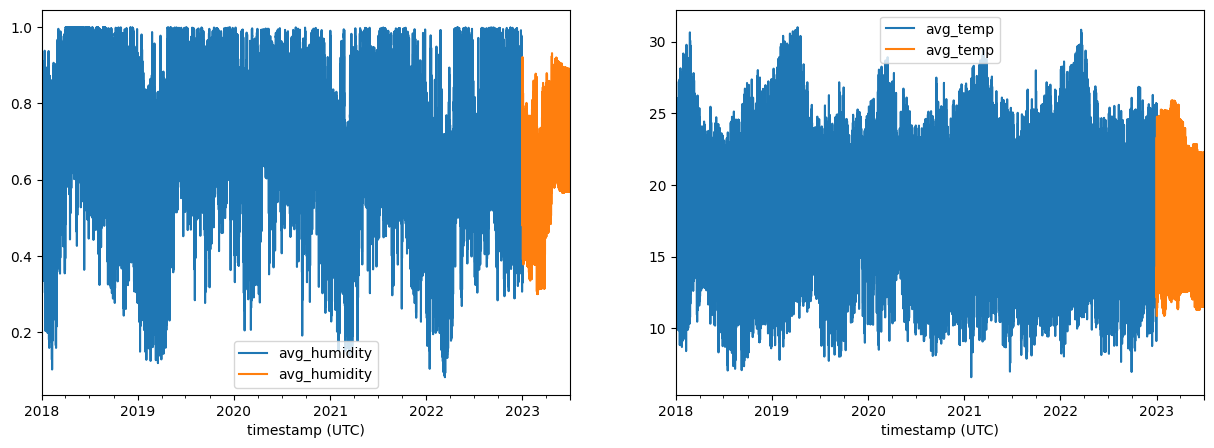

In [317]:
# combined[['avg_humidity','avg_temp']].plot()
fig, ax=plt.subplots(1,2,figsize=(15,5))
combined[['avg_humidity']].plot(ax=ax[0])
combined[['avg_temp']].plot(ax=ax[1])

In [318]:
print(combined.loc['2023-05-18 12:00:00'])

avg_humidity          NaN
avg_temp              NaN
avg_temp        22.026793
avg_humidity     0.590020
Name: 2023-05-18 12:00:00, dtype: float64


In [319]:
import pickle

def forectast(df):
    df.index=pd.to_datetime(df.index)
    df=create_features(df)
    loaded_model = pickle.load(open('reg.pkl', 'rb'))
    predictions = loaded_model.predict(df[features])
    df['avg_temp']=predictions[:,0]
    df['avg_humidity']=predictions[:,1]
    return df[['avg_temp','avg_humidity']]

forectast(sample)

,avg_temp,avg_humidity
timestamp (UTC),,
2023-01-01 00:00:00,14.207478,0.834627
2023-01-01 01:00:00,13.147409,0.868610
2023-01-01 02:00:00,12.451674,0.892104
2023-01-01 03:00:00,12.134332,0.911076
2023-01-01 04:00:00,13.004968,0.921768
...,...,...
2023-06-30 19:00:00,14.801343,0.790103
2023-06-30 20:00:00,14.213478,0.806078
2023-06-30 21:00:00,13.713581,0.816327
